# **L&T Vehicle Loan Default Prediction 👉 [Click!](https://www.kaggle.com/code/vishwanathkannan/l-t-vehicle-loan-default-prediction)**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
#ensemble
from xgboost import XGBClassifier
#metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,confusion_matrix

#warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
url="https://drive.google.com/file/d/1XZ6ObrgYMf-icEtRalFHkLQFuFne7ayc/view?usp=sharing"
path='https://drive.google.com/uc?id='+url.split('/')[-2]
print("▶ 공유파일 링크변환 경로명 : ", path)
df=pd.read_csv(path)
df.head()

▶ 공유파일 링크변환 경로명 :  https://drive.google.com/uc?id=1XZ6ObrgYMf-icEtRalFHkLQFuFne7ayc


,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [ ]:
df=df.drop(['UniqueID', 'branch_id','supplier_id', 'Current_pincode_ID','State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag'],axis=1)

In [ ]:
def credit_risk(df):
    d1=[]
    d2=[]
    for i in df:
        p = i.split("-")
        if len(p) == 1:
            d1.append(p[0])
            d2.append('unknown')
        else:
            d1.append(p[1])
            d2.append(p[0])

    return d2

sub_risk = {'unknown':-1, 'A':13, 'B':12, 'C':11,'D':10,'E':9,'F':8,'G':7,'H':6,'I':5,'J':4,'K':3, 'L':2,'M':1}
employment_map = {'Self employed':0, 'Salaried':1,np.nan:2}

df.loc[:,'credit_risk_grade']  = credit_risk(df["PERFORM_CNS.SCORE.DESCRIPTION"])
df.loc[:,'Credit Risk'] = df['credit_risk_grade'].apply(lambda x: sub_risk[x])

df.loc[:,'Employment Type'] = df['Employment.Type'].apply(lambda x: employment_map[x])

df=df.drop(['PERFORM_CNS.SCORE.DESCRIPTION', 'credit_risk_grade','Employment.Type'],axis=1)

In [ ]:
def age(dur):
    yr = int(dur.split('-')[2])
    if yr >=0 and yr<=19:
        return yr+2000
    else:
         return yr+1900

df['Date.of.Birth'] = df['Date.of.Birth'].apply(age)
df['DisbursalDate'] = df['DisbursalDate'].apply(age)
df['Age']=df['DisbursalDate']-df['Date.of.Birth']
df=df.drop(['DisbursalDate','Date.of.Birth'],axis=1)

In [ ]:
numerical=['disbursed_amount','asset_cost','PRI.NO.OF.ACCTS',
       'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
       'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
       'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE',
       'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT',
       'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','NO.OF_INQUIRIES','Age','NEW.ACCTS.IN.LAST.SIX.MONTHS', 
        'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']
categorical=['manufacturer_id', 'Aadhar_flag', 'PAN_flag',
       'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'NO.OF_INQUIRIES', 'Credit Risk','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH',
       'Employment Type']

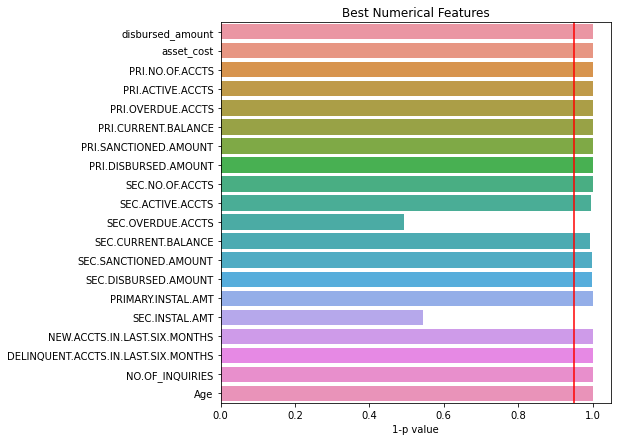

In [ ]:
#T Test for numerical columns
p=[]
from scipy.stats import ttest_ind

for i in numerical:
    df1=df.groupby('loan_default').get_group(0)
    df2=df.groupby('loan_default').get_group(1)
    t,pvalue=ttest_ind(df1[i],df2[i])
    p.append(1-pvalue)
plt.figure(figsize=(7,7))
sns.barplot(x=p, y=numerical)
plt.title('Best Numerical Features')
plt.axvline(x=(1-0.05),color='r')
plt.xlabel('1-p value')
plt.show()

In [ ]:
for i in numerical:
    df1=df.groupby('loan_default').get_group(0)
    df2=df.groupby('loan_default').get_group(1)
    print(np.std(df1[i],ddof=1),np.std(df2[i],ddof=1))

13140.699007454747 12150.255527172361
19015.002867400784 18680.50260861944
5.261141650230395 5.040133626442075
2.00824201211921 1.669965727209364
0.5320262425891056 0.6034839757822149
994631.7352945375 720451.2837836256
1234346.7457193038 4525738.059420641
1240214.8264108973 4527095.229860132
0.6516570890284885 0.5273583476262503
0.3233747412831527 0.28809588122653623
0.11124913670225146 0.11046343401346292
184110.75765852304 106044.42506894954
195212.28973438882 130717.868085271
194597.53945618658 130392.7661245395
157963.98513594718 124665.51133348931
16588.052553484686 11045.628444415664
0.9729689997391793 0.885661148793889
0.3702351321845456 0.43087164170442177
0.6655358308412611 0.8351467924441973
9.837771953397374 9.658768844799795
0.9729689997391793 0.885661148793889
0.3702351321845456 0.43087164170442177


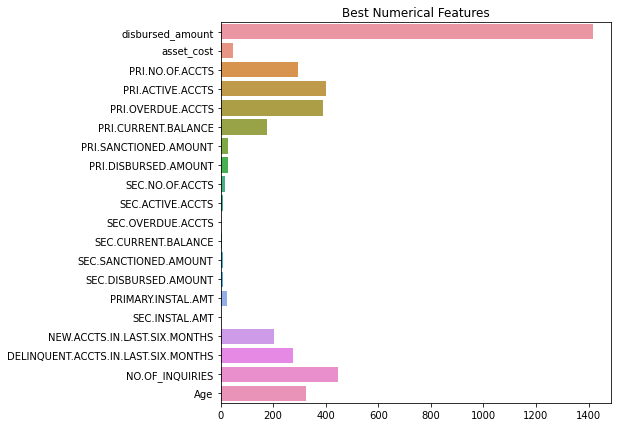

In [ ]:
from sklearn.feature_selection import SelectKBest,f_classif
n = SelectKBest(score_func=f_classif, k=10)
numcols=n.fit(df[numerical],df['loan_default'])
plt.figure(figsize=(7,7))
sns.barplot(x=numcols.scores_,y=numerical)
plt.title('Best Numerical Features')
plt.show()

In [ ]:
df.loc[:,'No of Accounts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']
df.loc[:,'PRI Inactive accounts'] = df['PRI.NO.OF.ACCTS'] - df['PRI.ACTIVE.ACCTS']
df.loc[:,'SEC Inactive accounts'] = df['SEC.NO.OF.ACCTS'] - df['SEC.ACTIVE.ACCTS']
df.loc[:,'Total Inactive accounts'] = df['PRI Inactive accounts'] + df['SEC Inactive accounts']
df.loc[:,'Total Overdue Accounts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
df.loc[:,'Total Current Balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']
df.loc[:,'Total Sanctioned Amount'] = df['PRI.SANCTIONED.AMOUNT'] + df['SEC.SANCTIONED.AMOUNT']
df.loc[:,'Total Disbursed Amount'] = df['PRI.DISBURSED.AMOUNT'] + df['SEC.DISBURSED.AMOUNT']
df.loc[:,'Total Installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']

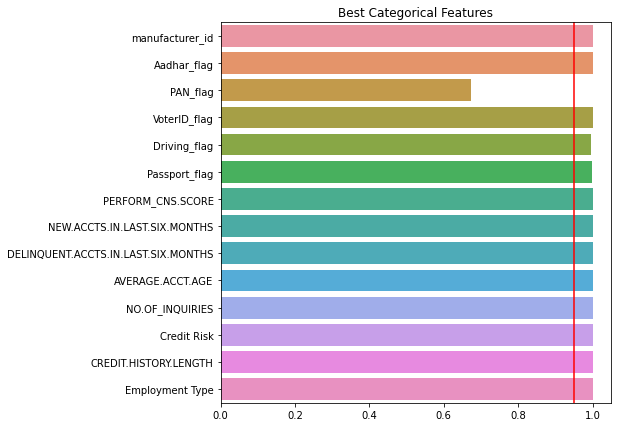

In [ ]:
#Chi Square test for Categorical Columns
from scipy.stats import chi2_contingency
l=[]
for i in categorical:
    pvalue  = chi2_contingency(pd.crosstab(df['loan_default'],df[i]))[1]
    l.append(1-pvalue)
plt.figure(figsize=(7,7))
sns.barplot(x=l, y=categorical)
plt.title('Best Categorical Features')
plt.axvline(x=(1-0.05),color='r')
plt.show()

In [ ]:
def duration(dur):
    yrs = int(dur.split(' ')[0].replace('yrs',''))
    mon = int(dur.split(' ')[1].replace('mon',''))
    return yrs*12+mon

In [ ]:
df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(duration)
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(duration)
#df.drop(['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'],axis=1,inplace=True)

In [ ]:
df=df.drop(['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS','PRI.CURRENT.BALANCE','PRI Inactive accounts','SEC Inactive accounts',
            'PRI.SANCTIONED.AMOUNT','SEC.NO.OF.ACCTS','PRI.NO.OF.ACCTS','PRI.DISBURSED.AMOUNT','PRI.ACTIVE.ACCTS', 
            'PRI.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.SANCTIONED.AMOUNT', 'SEC.OVERDUE.ACCTS',
            'SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT','disbursed_amount','SEC.ACTIVE.ACCTS'],axis=1)

In [ ]:
nums=['asset_cost', 'ltv','PERFORM_CNS.SCORE',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','No of Accounts', 'Total Inactive accounts',
       'Total Overdue Accounts', 'Total Current Balance', 'Total Sanctioned Amount',
       'Total Disbursed Amount', 'Total Installment','Age']

In [ ]:
len(nums)

16

In [ ]:
y=df.loan_default
X=df.drop("loan_default",axis=1)
from sklearn.model_selection import train_test_split,KFold,cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
print('train accuracy :',lr.score(X_train,y_train))
print('test accuracy :',lr.score(X_test,y_test))
print("precision :",precision_score(y_test,y_pred),"\n")
print("recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")
print(classification_report(y_test,y_pred))

train accuracy : 0.7829443590042093
test accuracy : 0.7827783893519379
precision : 0.0 

recall : 0.0 

f1 score: 0.0 

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     54756
           1       0.00      0.00      0.00     15191

    accuracy                           0.78     69947
   macro avg       0.39      0.50      0.44     69947
weighted avg       0.61      0.78      0.69     69947



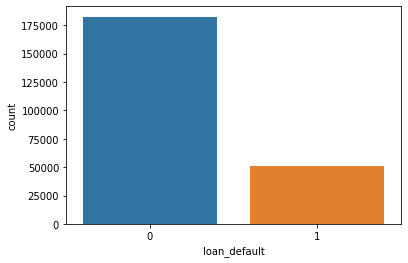

In [ ]:
sns.countplot(df['loan_default'])

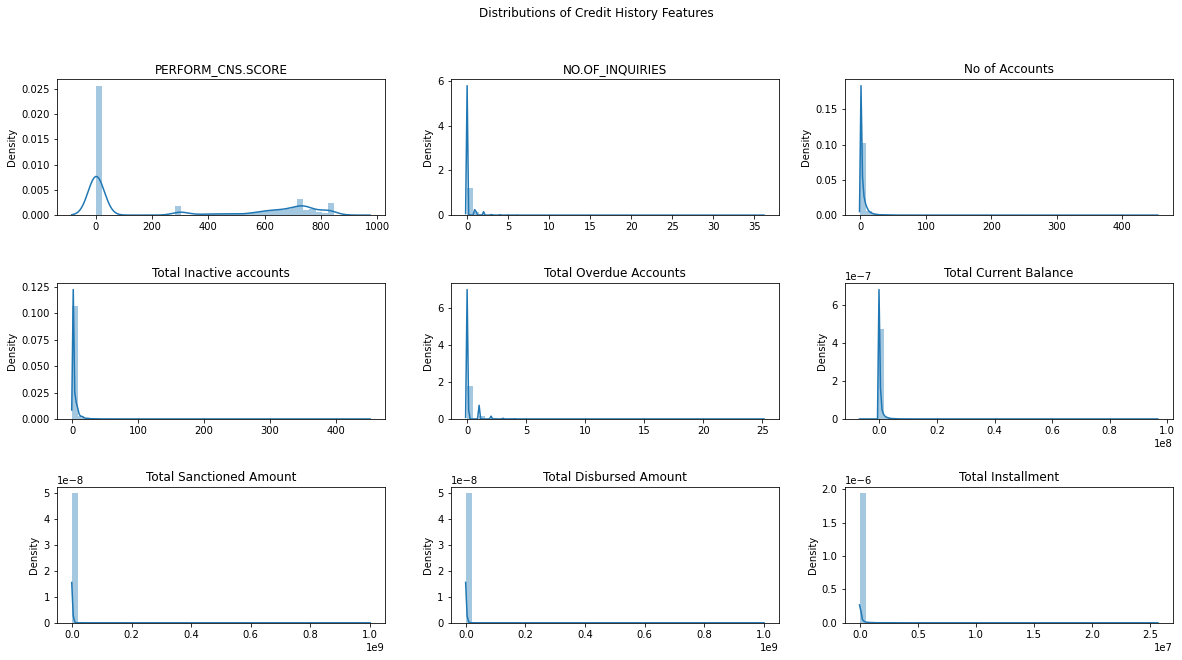

In [ ]:
n=['PERFORM_CNS.SCORE','NO.OF_INQUIRIES','No of Accounts', 'Total Inactive accounts',
       'Total Overdue Accounts', 'Total Current Balance', 'Total Sanctioned Amount',
       'Total Disbursed Amount', 'Total Installment']
data=df[n]
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Distributions of Credit History Features')

for ax, feature, name in zip(axes.flatten(), data.values.T, data.columns):
    sns.distplot(feature, ax=ax)
    ax.set(title=str(name))
plt.show()

In [ ]:
from sklearn.preprocessing import  RobustScaler
rob_scaler = RobustScaler()

df[nums] = rob_scaler.fit_transform(df[nums])

In [ ]:
df['Missing Features'] = (df == 0).astype(int).sum(axis=1)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=3)
gsearch1.fit(X_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 46.92088286,  46.3530407 ,  44.7361331 ,  71.67061289,
          70.0674235 ,  69.34297236, 104.2019577 , 101.45946542,
          99.18253692, 139.0619626 , 134.2245388 , 105.85607608]),
  'mean_score_time': array([0.9438649 , 0.85897851, 0.88535094, 1.07711109, 1.02577639,
         1.13081177, 1.54295389, 1.55074787, 1.47755353, 2.0850486 ,
         2.0658826 , 0.77972531]),
  'mean_test_score': array([0.64146363, 0.64156507, 0.64152969, 0.64212652, 0.64259441,
         0.64261645, 0.63925252, 0.64028214, 0.6394279 , 0.63438209,
         0.63501825, 0.63561224]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5],
               mask=[False, False, False, False, False, Fals

In [ ]:
param_test2b = {
 'max_depth':range(7,10,2)
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4, cv=3)
gsearch2b.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=4,
                                     n_estimators=140, nthread=4, seed=27,
                                     subsample=0.8),
             n_jobs=4, param_grid={'max_depth': range(7, 10, 2)},
             scoring='roc_auc')

In [ ]:
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

({'mean_fit_time': array([122.62555377, 108.91356587]),
  'mean_score_time': array([1.79833372, 1.13080668]),
  'mean_test_score': array([0.63925252, 0.63438209]),
  'param_max_depth': masked_array(data=[7, 9],
               mask=[False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 7}, {'max_depth': 9}],
  'rank_test_score': array([1, 2], dtype=int32),
  'split0_test_score': array([0.63853733, 0.63403581]),
  'split1_test_score': array([0.63722907, 0.63201337]),
  'split2_test_score': array([0.64199115, 0.63709708]),
  'std_fit_time': array([ 0.28139936, 31.6560921 ]),
  'std_score_time': array([0.07660336, 0.53988244]),
  'std_test_score': array([0.00200881, 0.00208981])},
 {'max_depth': 7},
 0.6392525152328178)

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.1}, 0.6372850678889052)

In [ ]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=9,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [ ]:
xgb4.fit(X_train,y_train)
y_pred=xgb4.predict(X_test)
print("accuracy train:",xgb4.score(X_train,y_train),"\n")
print("accuracy test:",xgb4.score(X_test,y_test),"\n")
print("precision :",precision_score(y_test,y_pred),"\n")
print("Recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")
print("Confusion Matrix \n",confusion_matrix(y_test,y_pred))

accuracy train: 0.8380339078593443 

accuracy test: 0.7819063004846527 

precision : 0.463718820861678 

Recall : 0.026923836482127577 

f1 score: 0.050892801592733156 

Confusion Matrix 
 [[54283   473]
 [14782   409]]


In [ ]:
import sklearn.metrics as metrics

In [ ]:
probs = xgb4.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)

In [ ]:
print(fpr, tpr)

[0.         0.         0.         ... 0.99981737 0.99981737 1.        ] [0.00000000e+00 6.58284511e-05 3.94970706e-04 ... 9.99934172e-01
 1.00000000e+00 1.00000000e+00]


In [ ]:
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-AUC Curve')
plt.show()

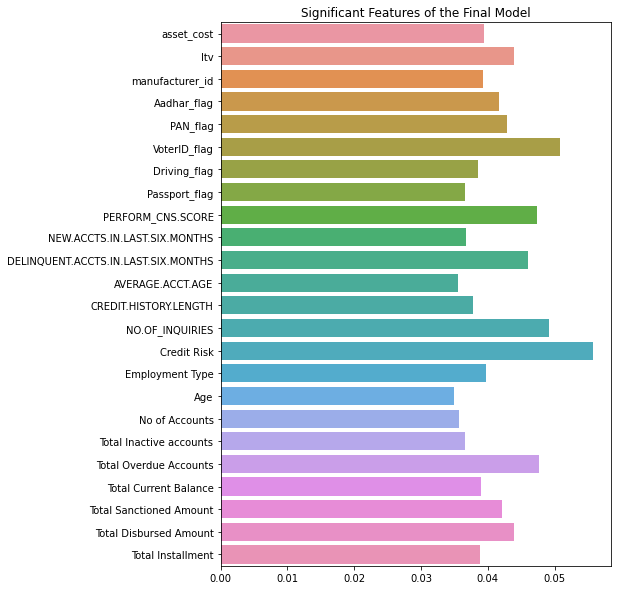

In [ ]:
plt.figure(figsize=(7,10))
sns.barplot(x=xgb4.feature_importances_,y=X.columns)
plt.title('Significant Features of the Final Model')
plt.show()

In [1]:
import pandas as pd

In [ ]:
df = pd.read